In [130]:
from Aggregator.SimulatedAggregator import SimulatedAggregator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from random import *

from collections import defaultdict

In [106]:
agg = SimulatedAggregator(10, None, 5)


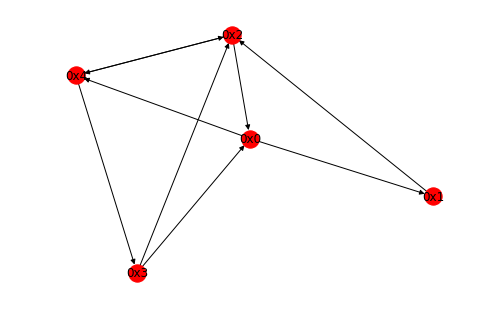

In [107]:
nx.draw(agg.networks[0], with_labels=True)
plt.show()

In [109]:
matrix = agg.matrices[0]

In [119]:
goal = agg.goal_balance[0]

def mutate(matrix, amount):
    x, y = matrix.shape
    x1, y1 = randint(0, x-1), randint(0, y-1)
    x2, y2 = randint(0, x-1), randint(0, y-1)
        
    matrix[x1, y1] -= amount
    matrix[x2, y2] += amount
    
    return matrix

def base_individual(base_matrix):
    matrix = base_matrix.copy()
    
    individual = { "matrix": matrix }
    update_individual(individual)
    
    return individual

def update_individual(individual):
    cons_violation, cost = agg.block_cost(individual["matrix"], goal)
    
    individual["cons_violation"] = cons_violation
    individual["cost"] = cost
    individual["valid"] = cons_violation == 0

In [86]:
calculate_end_balances = lambda matrix: np.array([matrix[:, i].sum() - row.sum() for i, row in enumerate(matrix)])

In [87]:
calculate_end_balances(matrix)

array([ -439,  1091,  -324,  1068, -1396], dtype=int32)

In [122]:
base_individual(matrix)

{'cons_violation': 0,
 'cost': 900,
 'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
 	with 9 stored elements in LInked List format>,
 'valid': True}

In [90]:
sum(agg.block_cost(matrix, agg.goal_balance[0]))

2800

In [140]:
population = {i: base_individual(matrix) for i in range(100)}

In [167]:
for i, individual in enumerate(population.values()):
    individual["matrix"] = mutate(individual["matrix"], randint(0, 100))
    
    update_individual(individual)

In [202]:
population

{0: {'cons_violation': 2960,
  'cost': 1200,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 1: {'cons_violation': 6020,
  'cost': 1200,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 2: {'cons_violation': 1740,
  'cost': 1000,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements in LInked List format>,
  'valid': False},
 3: {'cons_violation': 2760,
  'cost': 1400,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 14 stored elements in LInked List format>,
  'valid': False},
 4: {'cons_violation': 1360,
  'cost': 1000,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements in LInked List format>,
  'valid': False},
 5: {'cons_violation': 3080,
  'cost': 1300,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  

In [240]:
def fast_non_dominant_sort(P):
    Sx = defaultdict(list) # dict nondominating per p 
    nx = defaultdict(int)  # dict increment dominination counter of p 
    xrank = np.zeros(len(P))
    Fi = []
    
    correction = 1
    for pid, pv in P.items():
        for qid, qv in P.items():
            if pv["cost"] <= qv["cost"]: # if p dominates q -> less cost
                Sx[pid].append(qid)
            else:
                nx[pid] += 1
                
        if nx[pid] == 0:
            xrank[pid] = correction
#             correction += 1
            Fi.append(pid)
                        
    i = 1
    while Fi:
        Q = []
        
        for p in xrank:
#             correction = 0
            
            for qid, qv in Sx.items():
                nx[qid] -= 1
                
                if nx[qid] == 0: # q belongs to the next front
                    xrank[qid] = i + 1
#                     i += 1
#                     correction += 1
                    Q.append(qid)
                    
            i += 1
#             i -= correction
#             correction = 0
            
            Fi = Q
            
    return xrank          
            

In [296]:
POSITIVE_INFINITY = float("inf")

def crowding_distance(front):
    for p in population.values():
        p["crowding_dist"] = 0.
    
    n_solutions = len(front)
    
    x, y = solutions[0].shape
    
    for i in range(x):
        for j in range(y):
            sorted_solutions = sorted(front.values(), key=lambda x: x["matrix"][i, j])      
            sorted_solutions, matrices = zip(*[(x, x["matrix"]) for x in sorted_solutions])

            min_value = matrices[0][i, j]
            max_value = matrices[-1][i, j]
            
            sorted_solutions[0]["crowding_dist"] += POSITIVE_INFINITY
            sorted_solutions[-1]["crowding_dist"] += POSITIVE_INFINITY
            
            for s in range(1, n_solutions-1):
                diff = matrices[i+1][i, j] - matrices[i-1][i, j]
                sorted_solutions[s]["crowding_dist"] += diff / (max_value - min_value)

In [297]:
crowding_distance(population)

In [298]:
population

{0: {'cons_violation': 2960,
  'cost': 1200,
  'crowding_dist': inf,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 1: {'cons_violation': 6020,
  'cost': 1200,
  'crowding_dist': inf,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 2: {'cons_violation': 1740,
  'cost': 1000,
  'crowding_dist': inf,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements in LInked List format>,
  'valid': False},
 3: {'cons_violation': 2760,
  'cost': 1400,
  'crowding_dist': -2.4663792102018331,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 14 stored elements in LInked List format>,
  'valid': False},
 4: {'cons_violation': 1360,
  'cost': 1000,
  'crowding_dist': -2.4663792102018331,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements i

In [241]:
fast_non_dominant_sort(population)

array([  21.,   21.,    1.,   87.,    1.,   57.,    5.,   21.,   21.,
         21.,    1.,   21.,   21.,   57.,   21.,   21.,   21.,   57.,
         21.,   87.,   21.,   21.,   57.,   87.,    5.,   57.,   21.,
         21.,   21.,  100.,   21.,   87.,   57.,   57.,    5.,   21.,
          5.,    5.,    5.,   21.,    1.,   87.,   87.,    5.,   21.,
         21.,   57.,   21.,   57.,   57.,   21.,   21.,   57.,    5.,
         87.,   87.,   21.,    5.,   21.,   57.,   57.,   57.,   57.,
         87.,   57.,    5.,   21.,   21.,   57.,   21.,   21.,    5.,
         87.,   57.,    5.,   21.,   57.,   57.,   57.,    5.,   21.,
         57.,   57.,   87.,   87.,   57.,   21.,   57.,   57.,    5.,
         57.,   57.,   57.,    5.,    5.,   21.,   21.,   87.,   21.,   57.])

In [255]:
population

{0: {'cons_violation': 2960,
  'cost': 1200,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 1: {'cons_violation': 6020,
  'cost': 1200,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 12 stored elements in LInked List format>,
  'valid': False},
 2: {'cons_violation': 1740,
  'cost': 1000,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements in LInked List format>,
  'valid': False},
 3: {'cons_violation': 2760,
  'cost': 1400,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 14 stored elements in LInked List format>,
  'valid': False},
 4: {'cons_violation': 1360,
  'cost': 1000,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  	with 10 stored elements in LInked List format>,
  'valid': False},
 5: {'cons_violation': 3080,
  'cost': 1300,
  'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
  

In [ ]:
# Page 5